In [1]:
# Install Packages
# ! pip install pyspark
# ! pip install folium
# ! pip install geopandas

In [2]:
from pyspark.sql import SparkSession
import os
os.environ['PYTHONIOENCODING'] = 'utf-8'  # for python3 compatibility
from pyspark.sql.functions import year, month, weekofyear, dayofmonth, avg, col, when, expr
from pyspark.sql.window import Window
import seaborn as sns
import folium
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import geopandas as gpd
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from branca.colormap import linear
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType,TimestampType

In [3]:
# Créé une session spark
spark = SparkSession.builder.appName("projet_final").getOrCreate()

In [4]:
spark

# Préparation des données – étape 1

Nous utilisons des données de 2019 à 2021

In [5]:
# Fonction pour charger les données
def Dataloader(directory_path, delimiter, header):
    # Liste pour stocker les DataFrames individuels
    dataframes = []

    # Lire tous les fichiers CSV gzippés dans le répertoire
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".csv.gz"):
            file_path = os.path.join(directory_path, file_name)
            
            # Lire le fichier CSV gzippé sans entête avec le séparateur ;
            df = spark.read.option("header", "false").option("delimiter", delimiter).option("inferSchema", "true").csv(file_path)
            
            # Ajouter le DataFrame à la liste
            dataframes.append(df)

    # Fusionner les DataFrames en un seul DataFrame
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = merged_df.union(df)

    # Définir l'en-tête que vous souhaitez ajouter
    header = header

    # Ajouter l'en-tête au DataFrame
    data = merged_df.toDF(*header)

    # return le dataframe
    return data


## Chargement des données concernant les prix des carburants

In [6]:
# Définir le chemin du répertoire contenant les fichiers CSV gzippés
directory_path = "D:/MAG 3/Outils des big data/project/Mes_fichiers/Prix"
delimiter = ";"
# Définir l'en-tête que vous souhaitez ajouter
header = ['id', 'cp', 'pop', 'lat', 'long', 'date', 'type', 'name', 'prix']

prices_ddf = Dataloader(directory_path, delimiter, header)
# Changement du type de la colonne "prix" de DoubleType à FloatType
prices_ddf = prices_ddf.withColumn("id", prices_ddf["id"].cast(StringType()))
prices_ddf.printSchema()

root
 |-- id: string (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- type: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- prix: integer (nullable = true)



In [7]:
prices_ddf.show()

+-------+----+---+---------+--------+-------------------+----+------+----+
|     id|  cp|pop|      lat|    long|               date|type|  name|prix|
+-------+----+---+---------+--------+-------------------+----+------+----+
|1000001|1000|  R|4620114.0|519791.0|2019-01-04 10:53:48|   1|Gazole|1328|
|1000001|1000|  R|4620114.0|519791.0|2019-01-07 10:25:25|   1|Gazole|1348|
|1000001|1000|  R|4620114.0|519791.0|2019-01-10 08:54:28|   1|Gazole|1374|
|1000001|1000|  R|4620114.0|519791.0|2019-01-11 10:01:54|   1|Gazole|1387|
|1000001|1000|  R|4620114.0|519791.0|2019-01-14 11:04:53|   1|Gazole|1394|
|1000001|1000|  R|4620114.0|519791.0|2019-01-16 10:21:21|   1|Gazole|1394|
|1000001|1000|  R|4620114.0|519791.0|2019-01-17 08:30:12|   1|Gazole|1391|
|1000001|1000|  R|4620114.0|519791.0|2019-01-18 10:08:25|   1|Gazole|1401|
|1000001|1000|  R|4620114.0|519791.0|2019-01-21 10:30:12|   1|Gazole|1401|
|1000001|1000|  R|4620114.0|519791.0|2019-01-21 10:30:14|   1|Gazole|1401|
|1000001|1000|  R|4620114

## Chargement des données concernant les stations

In [8]:
directory_path = "D:/MAG 3/Outils des big data/project/Mes_fichiers/Stations"
delimiter = "|"
header = ['id', 'cp', 'pop', 'lat', 'long', 'adress', 'city']
stations_ddf = Dataloader(directory_path, delimiter, header)
stations_ddf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- adress: string (nullable = true)
 |-- city: string (nullable = true)



In [9]:
stations_ddf.show()

+-------+----+---+-------------+-------------+--------------------+--------------------+
|     id|  cp|pop|          lat|         long|              adress|                city|
+-------+----+---+-------------+-------------+--------------------+--------------------+
|1000001|1000|  R|    4620114.0|     519791.0|596 AVENUE DE TRE...|SAINT-DENIS-LèS-B...|
|1000002|1000|  R|    4621842.0|     522767.0| 16 Avenue de Marboz|     BOURG-EN-BRESSE|
|1000004|1000|  R|        5.245|       46.188|20 Avenue du Maré...|     Bourg-en-Bresse|
|1000005|1000|  R|4620093.59235|519942.024022|642 Avenue de Tré...|SAINT-DENIS-LèS-B...|
|1000006|1000|  R|    4620754.0|     523758.0|1 Boulevard John ...|     BOURG-EN-BRESSE|
|1000007|1000|  R|    4620105.0|     524891.0|360 AVENUE DU CAP...|     Bourg-en-Bresse|
|1000008|1000|  R|  4619941.651|   524070.357|Bd Charles de Gaulle|     BOURG-EN-BRESSE|
|1000009|1000|  R|    4619566.0|     522935.0|     56 Rue du Stand|     Bourg-en-Bresse|
|1000010|1000|  R|461

## Chargement des données des Services

In [10]:
directory_path = "D:/MAG 3/Outils des big data/project/Mes_fichiers/Services"
delimiter = "|"
header = ['id', 'cp', 'pop', 'lat', 'long', 'services']
services_ddf = Dataloader(directory_path, delimiter, header)
services_ddf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- services: string (nullable = true)



In [11]:
services_ddf.show()

+-------+----+---+-------------+-------------+--------------------+
|     id|  cp|pop|          lat|         long|            services|
+-------+----+---+-------------+-------------+--------------------+
|1000001|1000|  R|    4620114.0|     519791.0|Station de gonfla...|
|1000002|1000|  R|    4621842.0|     522767.0|Vente de gaz dome...|
|1000004|1000|  R|        5.245|       46.188|Carburant qualité...|
|1000005|1000|  R|4620093.59235|519942.024022|Carburant qualité...|
|1000006|1000|  R|    4620754.0|     523758.0|Vente de gaz dome...|
|1000007|1000|  R|    4620105.0|     524891.0|Station de lavage...|
|1000008|1000|  R|  4619941.651|   524070.357|Toilettes publiqu...|
|1000009|1000|  R|    4619566.0|     522935.0|Station de lavage...|
|1000010|1000|  R|4619851.83794|524350.637881|         Automate CB|
|1000012|1000|  R|    4620090.0|     519963.0|                NULL|
|1000013|1000|  R|4619851.83794|524350.637881|Carburant qualité...|
|1090001|1090|  R|        4.775|       46.096|  

In [12]:
# Fractionner la colonne date en année, mois et semaine
prices_ddf = prices_ddf.withColumn("year", year("date")) \
              .withColumn("month", month("date")) \
              .withColumn("week", weekofyear("date")) \
              .withColumn("day", dayofmonth("date"))


Rendre les données disponibles sous forme de tableau afin de pouvoir 
utiliser Spark SQL

In [13]:
prices_ddf.createOrReplaceTempView("prices")

Grâce à des statistiques de base, déterminez quels types de carburants présentent un certain intérêt pour la suite du projet. Deux d’entre eux présentent peu d’intérêt et pourront être filtrés pour la suite du projet.

In [14]:
# Affichons les différents types de carburants
spark.sql("""
SELECT DISTINCT(name)
FROM prices
""").show()

+------+
|  name|
+------+
|   E10|
|  SP98|
|   E85|
|Gazole|
|  SP95|
|  GPLc|
|  NULL|
+------+



## Statistique GPLc

In [15]:
spark.sql("""
SELECT name, year,
    avg(prix) as prix_moyen,
    min(prix) as prix_min,
    max(prix) as prix_max,
    count(*) as effectif,
    stddev(prix) as ecart_type
FROM prices
WHERE name = "GPLc"
GROUP BY name, year
ORDER BY name ASC;
""").show()

+----+----+-----------------+--------+--------+--------+-----------------+
|name|year|       prix_moyen|prix_min|prix_max|effectif|       ecart_type|
+----+----+-----------------+--------+--------+--------+-----------------+
|GPLc|2019| 878.224606956587|       1|    5000|  186557|  83.000233351849|
|GPLc|2020|869.8449011071307|       1|    2789|  178931|74.98734048769995|
|GPLc|2021|877.6477032656901|       1|    1999|  186025|73.00925046212011|
+----+----+-----------------+--------+--------+--------+-----------------+



## Statistique Gazole

In [16]:
spark.sql("""
SELECT name, year,
    avg(prix) as prix_moyen,
    min(prix) as prix_min,
    max(prix) as prix_max,
    count(*) as effectif,
    stddev(prix) as ecart_type
FROM prices
WHERE name = "Gazole"
GROUP BY name, year
ORDER BY name ASC;
""").show()

+------+----+------------------+--------+--------+--------+------------------+
|  name|year|        prix_moyen|prix_min|prix_max|effectif|        ecart_type|
+------+----+------------------+--------+--------+--------+------------------+
|Gazole|2019|1452.7359587122173|     136|    4640| 1304599| 71.57383277522393|
|Gazole|2020|1286.4448934011014|     106|    4480| 1177545|114.70754896127119|
|Gazole|2021|1455.9326413586728|     150|    8888| 1276540|105.74684008423482|
+------+----+------------------+--------+--------+--------+------------------+



## Statistique E85

In [17]:
spark.sql("""
SELECT name, year,
    avg(prix) as prix_moyen,
    min(prix) as prix_min,
    max(prix) as prix_max,
    count(*) as effectif,
    stddev(prix) as ecart_type
FROM prices
WHERE name = "E85"
GROUP BY name, year
ORDER BY name ASC;
""").show()

+----+----+-----------------+--------+--------+--------+-----------------+
|name|year|       prix_moyen|prix_min|prix_max|effectif|       ecart_type|
+----+----+-----------------+--------+--------+--------+-----------------+
| E85|2019|693.3245564869103|       1|    1804|  158789|77.79498408598604|
| E85|2020|695.4155365745052|       1|    3699|  222327|76.33121660323137|
| E85|2021|709.0367167073064|       1|    9659|  340390|66.21224973280225|
+----+----+-----------------+--------+--------+--------+-----------------+



## Statistique E10

In [18]:
spark.sql("""
SELECT name, year,
    avg(prix) as prix_moyen,
    min(prix) as prix_min,
    max(prix) as prix_max,
    count(*) as effectif,
    stddev(prix) as ecart_type
FROM prices
WHERE name = "E10"
GROUP BY name, year
ORDER BY name ASC;
""").show()

+----+----+------------------+--------+--------+--------+------------------+
|name|year|        prix_moyen|prix_min|prix_max|effectif|        ecart_type|
+----+----+------------------+--------+--------+--------+------------------+
| E10|2019| 1494.493615574274|      42|    6549| 1079267| 79.45178605028624|
| E10|2020|1361.7259444157573|     145|    8433|  979918|  106.054859732323|
| E10|2021| 1552.410615425065|     100|    8888| 1080164|100.38116808758444|
+----+----+------------------+--------+--------+--------+------------------+



## Statistique SP98

In [19]:
spark.sql("""
SELECT name, year,
    avg(prix) as prix_moyen,
    min(prix) as prix_min,
    max(prix) as prix_max,
    count(*) as effectif,
    stddev(prix) as ecart_type
FROM prices
WHERE name = "SP98"
GROUP BY name, year
ORDER BY name ASC;
""").show()

+----+----+------------------+--------+--------+--------+------------------+
|name|year|        prix_moyen|prix_min|prix_max|effectif|        ecart_type|
+----+----+------------------+--------+--------+--------+------------------+
|SP98|2019| 1580.293125871086|     372|    7589| 1115705| 85.08441478460423|
|SP98|2020|1446.9613888681915|     305|    5000| 1006575| 115.2349430033485|
|SP98|2021|1640.7435073669071|      10|    8888| 1104059|113.00412911095135|
+----+----+------------------+--------+--------+--------+------------------+



## Statistique SP95

In [20]:
spark.sql("""
SELECT name, year,
    avg(prix) as prix_moyen,
    min(prix) as prix_min,
    max(prix) as prix_max,
    count(*) as effectif,
    stddev(prix) as ecart_type
FROM prices
WHERE name = "SP95"
GROUP BY name, year
ORDER BY name ASC;
""").show()

+----+----+------------------+--------+--------+--------+-----------------+
|name|year|        prix_moyen|prix_min|prix_max|effectif|       ecart_type|
+----+----+------------------+--------+--------+--------+-----------------+
|SP95|2019|1512.4185166374493|      46|    8888|  366222|69.65288944473473|
|SP95|2020|1369.4331822235183|     132|    6652|  294929|102.2523750994615|
|SP95|2021|1563.7905157935206|      10|    4639|  296514| 90.8623912430779|
+----+----+------------------+--------+--------+--------+-----------------+



On observant les prix moyens, on peut détecter que les prix moyens de E85 et GPLc sont largement en dessous des autres. On peut conclure qu'ils ont peu d'intérêt. Donc on va pouvoir filtrer et éliminer ces deux types.

In [21]:
# On filtre  les données pour ne garder que les carburants qui ont d'intèrêt.
carburants_ddf = spark.sql("""
    SELECT *
    FROM prices
    WHERE name IN ("SP95", "E10", "Gazole", "SP98")
    """)
carburants_ddf.count()

11082037

In [22]:
carburants_ddf.select("name").distinct().show()

+------+
|  name|
+------+
|   E10|
|  SP98|
|Gazole|
|  SP95|
+------+



# Préparation des données – étape 2

Déterminons l'index de prix

In [23]:
# Ajoutez une colonne prix_moyen avec la moyenne groupée par jour et type de carburant
carburants_ddf = carburants_ddf.withColumn("prix_moyen", avg("prix")
                           .over(Window.partitionBy("day", "name")
))

# Affichez le DataFrame
carburants_ddf.show()

+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+
|     id|  cp|pop|          lat|         long|               date|type|name|prix|year|month|week|day|        prix_moyen|
+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+
|1000007|1000|  R|    4620105.0|     524891.0|2019-01-03 14:35:11|   5| E10|1320|2019|    1|   1|  3|1470.5647475524408|
|1000007|1000|  R|    4620105.0|     524891.0|2019-08-03 08:30:00|   5| E10|1411|2019|    8|  31|  3|1470.5647475524408|
|1000008|1000|  R|    4619900.0|     524100.0|2019-01-03 07:07:17|   5| E10|1339|2019|    1|   1|  3|1470.5647475524408|
|1000008|1000|  R|    4619900.0|     524100.0|2019-02-03 10:30:00|   5| E10|1383|2019|    2|   5|  3|1470.5647475524408|
|1000008|1000|  R|    4619900.0|     524100.0|2019-04-03 08:14:04|   5| E10|1479|2019|    4|  14|  3|1470.5647475524408|
|1000008|1000|  R|    4619900.0|

In [24]:
# Ajoutons la colonne Index_Prix
carburants_ddf = carburants_ddf.withColumn(
    "price_index",
    (col("Prix") - col("prix_moyen")) / col("prix_moyen") + 1
)

In [25]:
carburants_ddf.show()

+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+------------------+
|     id|  cp|pop|          lat|         long|               date|type|name|prix|year|month|week|day|        prix_moyen|       price_index|
+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+------------------+
|1000007|1000|  R|    4620105.0|     524891.0|2019-01-03 14:35:11|   5| E10|1320|2019|    1|   1|  3|1470.5647475524408|0.8976143363948879|
|1000007|1000|  R|    4620105.0|     524891.0|2019-08-03 08:30:00|   5| E10|1411|2019|    8|  31|  3|1470.5647475524408|0.9594953247372627|
|1000008|1000|  R|    4619900.0|     524100.0|2019-01-03 07:07:17|   5| E10|1339|2019|    1|   1|  3|1470.5647475524408| 0.910534542752087|
|1000008|1000|  R|    4619900.0|     524100.0|2019-02-03 10:30:00|   5| E10|1383|2019|    2|   5|  3|1470.5647475524408|0.9404550206319167|
|1000008|1000|  R|  

## Calculer l'index de la semaine

In [26]:
# Création de la variable Index_semaine
carburants_ddf = carburants_ddf.withColumn("Index_semaine",
                                        when(carburants_ddf.year == 2018, 52 + carburants_ddf.week)
                                       .when(carburants_ddf.year == 2019, 104 + carburants_ddf.week)
                                       .when(carburants_ddf.year == 2020, 156 + carburants_ddf.week)
                                       .when(carburants_ddf.year == 2021, 208 + carburants_ddf.week)
                                       .when(carburants_ddf.year == 2022, 260 + carburants_ddf.week)
                                       .when(carburants_ddf.year == 2023, 312 + carburants_ddf.week)
                                       .otherwise(carburants_ddf.week))

In [27]:
carburants_ddf.show()

+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+------------------+-------------+
|     id|  cp|pop|          lat|         long|               date|type|name|prix|year|month|week|day|        prix_moyen|       price_index|Index_semaine|
+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+------------------+-------------+
|1000007|1000|  R|    4620105.0|     524891.0|2019-01-03 14:35:11|   5| E10|1320|2019|    1|   1|  3|1470.5647475524408|0.8976143363948879|          105|
|1000007|1000|  R|    4620105.0|     524891.0|2019-08-03 08:30:00|   5| E10|1411|2019|    8|  31|  3|1470.5647475524408|0.9594953247372627|          135|
|1000008|1000|  R|    4619900.0|     524100.0|2019-01-03 07:07:17|   5| E10|1339|2019|    1|   1|  3|1470.5647475524408| 0.910534542752087|          105|
|1000008|1000|  R|    4619900.0|     524100.0|2019-02-03 10:30:00|   5| E10|

# Visualisation de données

In [28]:
# Calcul du prix moyen hebdomadaire pour chaque type de carburant
df_grouped = carburants_ddf.groupBy("Index_semaine", "name") \
    .agg(F.mean("prix").alias("prix_moyen_hebdo")).orderBy("Index_semaine", "name")

df_grouped.show()

+-------------+------+------------------+
|Index_semaine|  name|  prix_moyen_hebdo|
+-------------+------+------------------+
|          105|   E10|1431.2172373081464|
|          105|Gazole|1424.7996734815035|
|          105|  SP95|1455.3585618354784|
|          105|  SP98|1518.4946303919814|
|          106|   E10|1401.5876641651032|
|          106|Gazole|1399.0902171155171|
|          106|  SP95|1424.3998979201224|
|          106|  SP98| 1487.122976465787|
|          107|   E10|1414.5244974007453|
|          107|Gazole|1417.6400794367214|
|          107|  SP95| 1437.689259207394|
|          107|  SP98|1498.4357603605197|
|          108|   E10|1423.7141221175368|
|          108|Gazole| 1430.798795278137|
|          108|  SP95| 1443.903464947623|
|          108|  SP98|1507.8204912350202|
|          109|   E10|1423.0968766543144|
|          109|Gazole|1433.4229831189325|
|          109|  SP95|1439.1230118783974|
|          109|  SP98|1507.9108516252174|
+-------------+------+------------

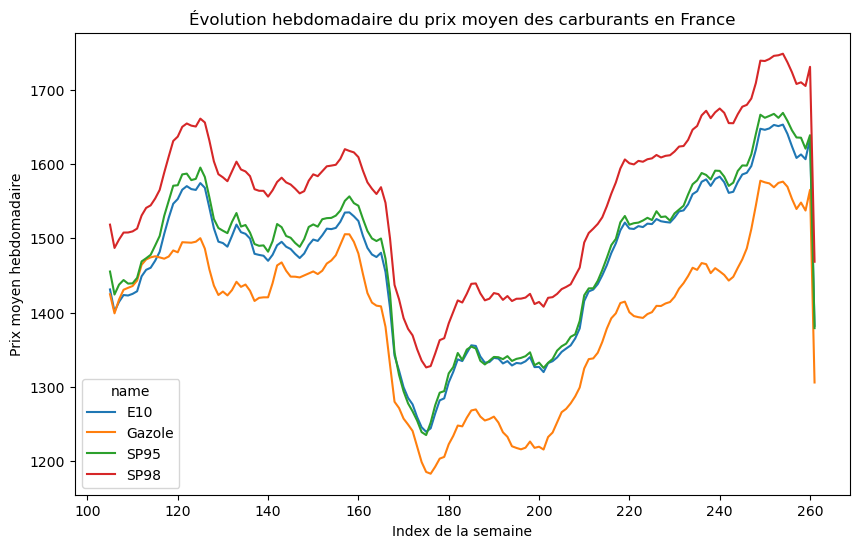

In [29]:
# Conversion du DataFrame PySpark en Pandas pour l'utilisation avec Seaborn
df_pandas = df_grouped.toPandas()

# Utilisation de Seaborn pour représenter l'évolution hebdomadaire en courbe
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pandas, x="Index_semaine", y="prix_moyen_hebdo", hue="name")

# Ajout de titres et labels
plt.title("Évolution hebdomadaire du prix moyen des carburants en France")
plt.xlabel("Index de la semaine")
plt.ylabel("Prix moyen hebdomadaire")

# Affichage du graphique
plt.show()

## Visualisation des données – Question bonus

In [30]:
# Ajout d'une colonne CodeDepartement
carburants_ddf = carburants_ddf.withColumn(
    "CodeDep",
    expr(
        "CASE WHEN length(cp) = 4 THEN concat('0', substr(cp, 1, 1))"
        "ELSE substr(cp, 1, 2) END"
    )
)
carburants_ddf.show()

+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+------------------+-------------+-------+
|     id|  cp|pop|          lat|         long|               date|type|name|prix|year|month|week|day|        prix_moyen|       price_index|Index_semaine|CodeDep|
+-------+----+---+-------------+-------------+-------------------+----+----+----+----+-----+----+---+------------------+------------------+-------------+-------+
|1000007|1000|  R|    4620105.0|     524891.0|2019-01-03 14:35:11|   5| E10|1320|2019|    1|   1|  3|1470.5647475524408|0.8976143363948879|          105|     01|
|1000007|1000|  R|    4620105.0|     524891.0|2019-08-03 08:30:00|   5| E10|1411|2019|    8|  31|  3|1470.5647475524408|0.9594953247372627|          135|     01|
|1000008|1000|  R|    4619900.0|     524100.0|2019-01-03 07:07:17|   5| E10|1339|2019|    1|   1|  3|1470.5647475524408| 0.910534542752087|          105|     01|
|1000008|1000|  R|    461990

In [31]:
# Filtrage sur un type de carburant et année spécifique (par exemple, "Gazole" et 2021)
filtered_ddf = carburants_ddf.filter((col("name") == "Gazole") & (col("year") == 2021))

# Calcul du prix moyen par département
avg_prices_ddf = filtered_ddf.groupBy("CodeDep").avg("Prix") \
                            .withColumnRenamed("avg(Prix)", "PrixMoyen") \
                            .orderBy("CodeDep")
avg_prices_ddf.show()

+-------+------------------+
|CodeDep|         PrixMoyen|
+-------+------------------+
|     01| 1468.235897052222|
|     02|1432.1782245532245|
|     03|1454.7990713381173|
|     04|1479.8825741746762|
|     05|1447.1478925314273|
|     06|1480.4338928316624|
|     07|1439.4049008168029|
|     08| 1449.964258841234|
|     09|            1427.9|
|     10|1450.6708860759493|
|     11|1459.4559935823975|
|     12|1457.4641101278269|
|     13|1449.7422940879233|
|     14| 1426.859552077712|
|     15| 1446.464973371569|
|     16|1430.2844728434504|
|     17|1427.9615285474933|
|     18|1438.1842494594287|
|     19| 1466.927841977963|
|     20| 1555.131241565452|
+-------+------------------+
only showing top 20 rows



In [32]:
# Chargement des données géographiques (par exemple, un fichier GeoJSON des départements français)
# Ce fichier est disponible au lien suivant : https://data.smartidf.services/explore/dataset/contours-des-departements-francais-issus-dopenstreetmap/export/?flg=fr-fr

geojson_path = "D:\MAG 3\Outils des big data\contours-des-departements-francais-issus-dopenstreetmap.geojson"
gdf = gpd.read_file(geojson_path)

In [33]:
gdf

,geo_point_2d,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,"{'lon': 5.34863678028, 'lat': 46.0997319897}",01,Ain,FR711,fr:Ain (dpartement),NaN,"POLYGON ((5.25559 45.78459, 5.23987 45.77758, ..."
1,"{'lon': 4.16152914458, 'lat': 48.3046157824}",10,Aube,FR212,fr:Aube (dpartement),NaN,"POLYGON ((3.69459 48.15489, 3.69187 48.15511, ..."
2,"{'lon': 5.08584432177, 'lat': 43.5431307943}",13,Bouches-du-Rhne,FR823,fr:Bouches-du-Rhne,NaN,"MULTIPOLYGON (((5.38913 43.18475, 5.38930 43.1..."
3,"{'lon': 2.49109671007, 'lat': 47.0657741976}",18,Cher,FR241,fr:Cher (dpartement),NaN,"POLYGON ((2.19769 46.42835, 2.18486 46.42306, ..."
4,"{'lon': 1.8776170491, 'lat': 45.3572857415}",19,Corrze,FR631,fr:Corrze (dpartement),NaN,"POLYGON ((2.36445 45.37487, 2.36752 45.36533, ..."
...,...,...,...,...,...,...,...
503,"{'lon': 2.678577370788869, 'lat': 44.281103367...",12,Aveyron,FR622,fr:Aveyron (département),8773.0,"POLYGON ((1.83966 44.47586, 1.83969 44.47613, ..."
504,"{'lon': -0.761279027506684, 'lat': 43.25627150...",64,Pyrénées-Atlantiques,FR615,fr:Pyrénées-Atlantiques,7683.0,"MULTIPOLYGON (((-1.79102 43.37292, -1.79048 43..."
505,"{'lon': 1.2348666287300387, 'lat': 45.89229414...",87,Haute-Vienne,FR633,fr:Haute-Vienne,5557.0,"POLYGON ((0.62934 45.71480, 0.62991 45.71511, ..."
506,"{'lon': 1.5759054970037312, 'lat': 46.77824308...",36,Indre,FR243,fr:Indre (département),6898.0,"POLYGON ((0.86711 46.74873, 0.87618 46.75100, ..."


### Affichage de la carte avec matplotlib

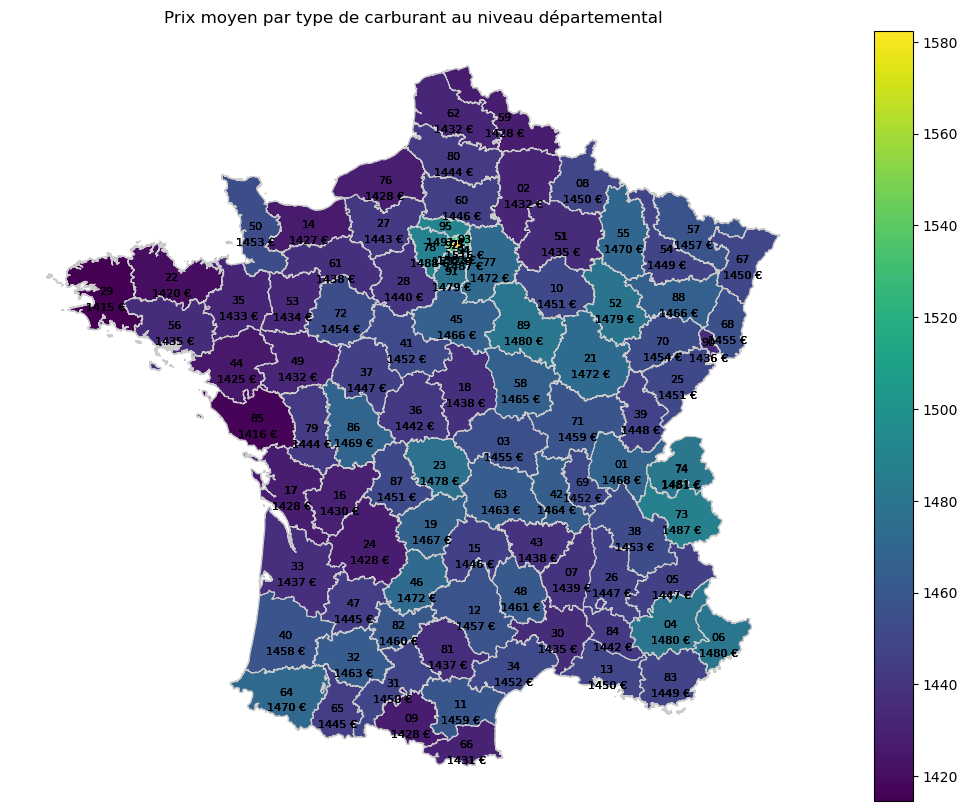

In [34]:

# Jointure entre le DataFrame des prix moyens et le GeoDataFrame des départements
gdf = gdf.merge(avg_prices_ddf.toPandas(), left_on="code_insee", right_on="CodeDep", how="inner")

# Représentation de la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column="PrixMoyen", cmap="viridis", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)


for index, row in gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    label = row["PrixMoyen"]
    code_departement = row["CodeDep"]
    ax.text(x, y - 0.2, f"{label:.0f} €", fontsize=8, ha="center", va="center")
    ax.text(x, y , f"{code_departement}", fontsize=8, ha="center", va="center")

# Personnalisation de la carte
ax.set_title("Prix moyen par type de carburant au niveau départemental")
ax.set_axis_off()

# Affichage de la carte
plt.show()


## Avec folium 

In [52]:
# Création de la carte Folium avec une palette de couleurs
map_center = [46.6031, 1.8883]  # Coordonnées pour le centre de la France
folium_map = folium.Map(location=map_center, zoom_start=6, control_scale=True, tiles='cartodb positron')

# Définition de la palette de couleurs
colormap = linear.viridis.scale(gdf['PrixMoyen'].min(), gdf['PrixMoyen'].max())

# Ajout des cercles interactifs pour chaque département avec couleur variable
for index, row in gdf.iterrows():
    popup_text = f"Département: {row['nom']}<br>Prix Moyen: {row['PrixMoyen']:.0f} €"
    folium.CircleMarker(location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
                        radius=10,
                        color=colormap(row['PrixMoyen']),
                        fill=True,
                        fill_color=colormap(row['PrixMoyen']),
                        fill_opacity=0.6,
                        popup=folium.Popup(popup_text, max_width=300)).add_to(folium_map)

# Ajout de la légende
colormap.caption = 'Prix Moyen (€)'
colormap.add_to(folium_map)

# Affichage de la carte
folium_map


# Modélisation – Prévision du prix le lendemain

In [36]:
carburants_ddf.printSchema()

root
 |-- id: string (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- type: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- prix: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- prix_moyen: double (nullable = true)
 |-- price_index: double (nullable = true)
 |-- Index_semaine: integer (nullable = true)
 |-- CodeDep: string (nullable = true)



### Pour la prédiction du prix du lendemain, nous allons utiliser LinearRegression. Etant donné qu'on a travaillé en local, sur un vscode avec ordinateur de Ram 8, on a été limité par la puissance de calcul. Pour cela on a fait qu'un seul modèle, sans cross validation, sans grid search.

In [43]:
# Création d'une fenêtre par type de carburant et station, triée par année, mois et jour
window_spec = Window().partitionBy("id", "name").orderBy("year", "month", "day")

# Créer une colonne "PrixLendemain" en décalant la colonne "Prix" d'un jour
modele_ddf = carburants_ddf.withColumn("PriceTomorrow", F.lead("prix").over(window_spec))

# Supprimer la dernière ligne qui aurait une valeur nulle pour "PrixLendemain"
modele_ddf = modele_ddf.na.drop(subset=["PriceTomorrow"])


In [44]:
modele_ddf.count()

11050021

In [45]:
modele_ddf.describe().show()

+-------+--------------------+------------------+--------+-----------------+------------------+------------------+--------+------------------+------------------+----------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+
|summary|                  id|                cp|     pop|              lat|              long|              type|    name|              prix|              year|           month|              week|               day|        prix_moyen|         price_index|    Index_semaine|           CodeDep|     PriceTomorrow|
+-------+--------------------+------------------+--------+-----------------+------------------+------------------+--------+------------------+------------------+----------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+
|  count|            11050021|          11050021|11050021|   

Pas de valeurs manquantes

In [46]:
# Convertir les variables catégorielles en indices avec StringIndexer
indexer_name = StringIndexer(inputCol="name", outputCol="NameIndex")
indexer_pop = StringIndexer(inputCol="pop", outputCol="PopIndex")
#indexer_id = StringIndexer(inputCol="id", outputCol="IdIndex")

# Appliquer OneHotEncoder sur les indices obtenus
encoder_name = OneHotEncoder(inputCol="NameIndex", outputCol="NameVec")
encoder_pop = OneHotEncoder(inputCol="PopIndex", outputCol="PopVec")
#encoder_id = OneHotEncoder(inputCol="IdIndex", outputCol="IdVec")

# Sélectionner les colonnes nécessaires pour le modèle
feature_columns = ["prix", "month", "week", "day", "lat", "long", "NameVec", "PopVec"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Initialiser le modèle de régression linéaire
lr = LinearRegression(featuresCol="features", labelCol="PriceTomorrow", maxIter=10, regParam=0.01, elasticNetParam=0.0)

# #Créer le pipeline avec l'assemblage et le modèle
pipeline = Pipeline(stages=[indexer_name, indexer_pop, encoder_name, encoder_pop, assembler, lr])

# Diviser les données en ensembles de formation et de test
(training_data, testing_data) = modele_ddf.randomSplit([0.8, 0.2], seed=42)

In [47]:
# Entraîner le modèle sur l'ensemble de formation
model = pipeline.fit(training_data)

# Faire des prédictions sur l'ensemble de test
predictions = model.transform(testing_data)

# Afficher les prédictions
predictions.select("prix", "PriceTomorrow", "prediction").show()

+----+-------------+------------------+
|prix|PriceTomorrow|        prediction|
+----+-------------+------------------+
|1439|         1439| 1442.956834062269|
|1439|         1442| 1442.810335721342|
|1449|         1452|  1452.40791718669|
|1452|         1459|1455.1435875690097|
|1472|         1472|1474.3532219179212|
|1472|         1472|1474.2067235769937|
|1476|         1477|1477.9079406731348|
|1476|         1477|1478.5965573408841|
|1486|         1486|1488.0765833017354|
|1486|         1486| 1488.083819010843|
|1486|         1489|1488.0910547199508|
|1504|         1499|1505.1796830456467|
|1499|         1503|1500.4025994402957|
|1507|         1509|1507.9225891370743|
|1509|         1514|1510.5567706506808|
|1514|         1515|1515.2235344606427|
|1532|         1532|1532.3555770409848|
|1609|         1614|1606.6062657717694|
|1624|         1619|1620.7168769970442|
|1629|         1629| 1625.537374857041|
+----+-------------+------------------+
only showing top 20 rows



In [48]:
# Évaluer le modèle en utilisant la métrique RMSE
evaluator = RegressionEvaluator(labelCol="PriceTomorrow", predictionCol="prediction", metricName="rmse")

# # Calculer la RMSE sur l'ensemble de test
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


Root Mean Squared Error (RMSE) on test data = 35.38171527113825


In [49]:
# Évaluation du modèle de régression linéaire
evaluator_lr = RegressionEvaluator(labelCol="PriceTomorrow", predictionCol="prediction", metricName="r2")
r2_lr = evaluator_lr.evaluate(predictions)
print(f"Linear Regression - R²: {r2_lr}")

Linear Regression - R²: 0.9369348684470089


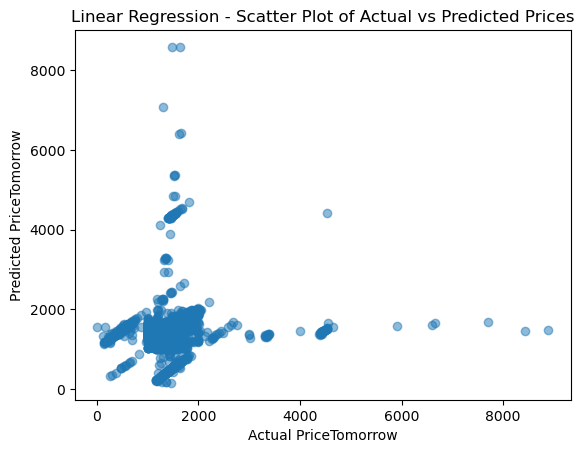

In [51]:
# Affichage du graphique de dispersion pour la régression linéaire
actual_prices_lr = np.array(predictions.select("PriceTomorrow").collect())
predicted_prices_lr = np.array(predictions.select("prediction").collect())

plt.scatter(actual_prices_lr, predicted_prices_lr, alpha=0.5)
plt.xlabel("Actual PriceTomorrow")
plt.ylabel("Predicted PriceTomorrow")
plt.title("Linear Regression - Scatter Plot of Actual vs Predicted Prices")
plt.show()

En conclusion, on peut noté une bonne performance globale du modèle, même s'il peut y avoir des erreurs de prédiction importantes pour certains observations spécifiques. Cela vaut la peine d'examiner ces points pour comprendre pourquoi le modèle a eu du mal à les prédire. On peut aussi envisager d'utiliser aussi d'autres modèles comme RandomForest pour la prédiction.

In [53]:
spark.stop()